In [1]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt, mpld3
network = pypsa.Network()

#FORMATTING
bus = pd.read_csv('../base_grid/bus.csv')
sub = pd.read_csv('../base_grid/sub.csv')
sub = sub.drop(columns = 'interconnect')
bus2sub = pd.read_csv('../base_grid/bus2sub.csv')
bus2sub = bus2sub.drop(columns = 'interconnect')
buses = bus.merge(bus2sub, how = 'left', on='bus_id')
buses = buses.merge(sub,how='left',on='sub_id')
buses['Va'] = buses['Va'].apply(np.deg2rad)
buses['control'] = buses['type'].map({1:'PQ',2:'PV'})
buses.drop(inplace=True,columns = ['type'])
buses.dropna(subset=['control'],inplace=True)
texas = buses[buses['interconnect'] == 'Texas']
texas = texas.set_index('bus_id')
buses_columns = {'lat':'y',
    'lon':'x',
    'Vm':'v_mag_pu',
    'Pd':'p',
    'Qd':'q',
    'Va':'v_ang',
    'baseKV':'v_nom',
    'Vmax':'v_mag_pu_max',
    'Vmin':'v_mag_pu_min'}

texas = texas.rename(columns = buses_columns)
texas = texas[buses_columns.values()]

#ADDING BUSES AND LOADS
for i in range(len(texas)):
    load = texas.iloc[i][3]
    network.add("Bus",texas.index[i], x = texas.iloc[i][1], y = texas.iloc[i][0])
    network.add("Load",texas.index[i], bus = texas.index[i], p_set = load)

#FORMATTING
generators = pd.read_csv('../base_grid/plant.csv')
cost = pd.read_csv('../base_grid/gencost.csv')
generators = generators.merge(cost.drop(columns = ['type','interconnect']),how='left',on='plant_id')
generators = generators.merge(bus.drop(columns = ['type', 'interconnect']),how='left',on='bus_id')
generators = generators.merge(bus[['bus_id','type']].rename(columns = {'type':'control'}),how='left',on='bus_id')
texas_generators = generators[generators.interconnect == 'Texas'].copy()
branches = pd.read_csv('../base_grid/branch.csv')
texas_branches = branches[branches['interconnect'] == 'Texas'].copy()
texas_branches.drop(103363, axis=0, inplace=True)
texas_generators.drop(13253, axis=0, inplace=True)
#ADDING LINES
for i in range(len(texas_branches)):
    name = texas_branches.iloc[i][0]
    busZero = texas_branches.iloc[i][1]
    busOne = texas_branches.iloc[i][2]
    react = texas_branches.iloc[i][4]
    resist = texas_branches.iloc[i][3]
    rateA = texas_branches.iloc[i][6]
    network.add("Line",name,bus0=busZero, bus1=busOne,x=react,r = resist, s_nom = rateA + 48)

#ADDING GENERATORS
texasNamesList = texas.index.values.tolist()
for i in range(len(texas)):
    busLoc = texas.iloc[i][1]
    genList = texas_generators.loc[:,'bus_id'].tolist()
    if texasNamesList[i] in genList:
        pMax = texas_generators.loc[texas_generators['bus_id'] == texasNamesList[i]].iloc[0,9]
        network.add("Generator", i, bus = texasNamesList[i],p_nom = pMax, marginal_cost = 1)
    

#Max hydro value: 675.2241546961308

In [2]:

# network.generators.p_nom.sum()
network.lines.s_nom.describe()

count    3205.000000
mean      473.853666
std       534.716073
min        67.000000
25%       235.000000
50%       269.000000
75%       457.000000
max      4400.000000
Name: s_nom, dtype: float64

In [3]:
network.lopf(solver_name='gurobi',pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 13.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-30
Read LP format model from file C:\Users\edwar\AppData\Local\Temp\pypsa-problem-ekmw2hj7.lp
Reading time = 0.13 seconds
obj: 10662 rows, 3729 columns, 55826 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10662 rows, 3729 columns and 55826 nonzeros
Model fingerprint: 0xa401c1bb
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 4e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 9139 rows and 1985 columns
Presolve time: 0.10s
Presolved: 1523 rows, 1744 columns, 32251 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.012e+04
 Factor NZ  : 1.333e+05 (roughly 2 MB of memory)
 Factor Ops : 1.705e+07 (less than 1 second p

INFO:pypsa.linopf:Optimization successful. Objective value: 6.71e+04


('ok', 'optimal')

In [4]:
network.buses_t.p.T.describe()

snapshot,now
count,1.999000e+03
mean,2.042126e-13
std,1.223508e+02
min,-2.854100e+02
25%,-5.250000e+01
50%,-6.420000e+00
75%,0.000000e+00
max,9.320000e+02


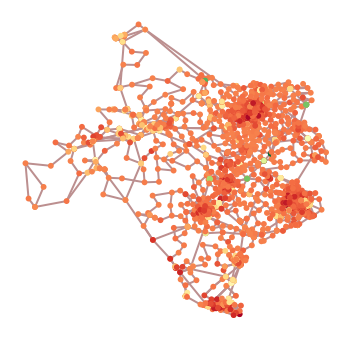

In [10]:
busValue = list(network.buses.index)
lineValue = list(network.lines.index)
color = network.buses_t.p.squeeze()
fig, ax = plt.subplots(figsize=(12, 6))
data = network.plot(bus_colors=color, bus_cmap=plt.cm.RdYlGn, line_widths = 2.0, bus_sizes = .01)

busTooltip = mpld3.plugins.PointHTMLTooltip(data[0], busValue,0,0,-50)
lineTooltip = mpld3.plugins.PointHTMLTooltip(data[1], lineValue, 0, 0, -50)
fileName = "network" + str(3) + ".html" 
mpld3.plugins.connect(fig,lineTooltip)
mpld3.plugins.connect(fig,busTooltip)
mpld3.save_html(fig, fileName)

In [ ]:
network.export_to_netcdf('FinalTexasGrid.py')